## 1 Prediction Model: an application of Convolutional Neural Networks on Graphs



This code was inspired by the [Graph Conv Net] library, whose algorithm was proposed in the [paper] *Convolutional Neural Networks on Graphs with Fast Localized Spectral Filtering*. 

[Graph Conv Net]: https://github.com/mdeff/cnn_graph, 
[paper]: https://arxiv.org/abs/1606.09375

In [1]:
import os
import pandas as pd
pd.options.mode.chained_assignment = None

import numpy as np
import ast
from scipy import sparse
import seaborn as sns
import networkx as nx
import tensorflow as tf

import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
mycmap = ListedColormap(['blue','white','red'])
%matplotlib inline 

import warnings
warnings.filterwarnings("ignore",category=matplotlib.cbook.mplDeprecation)

%load_ext autoreload
%autoreload

from lib import models_alt, graph
tf.logging.set_verbosity(tf.logging.ERROR)

In [2]:
VOTES_PATH = '../data/votes/votes_{}.csv'
BILLS_PATH = '../data/bills/bills_{}.csv'
SEED = 123
np.random.seed(SEED)

The CNN code as proposed in the reference was adapted for the regression problem, using Mean Squared Error as cost function, for an input tensor of and label tensor of dimension $N_{tr}\times N_{s}$, where $N_{tr}$ is the training set length and $N_{s}$ is the number of senators. 

Further details on the changes made can bee seen in `lib/models_alt.py`.

In [3]:
params = dict()
params['dir_name'] = 'demo'
params['num_epochs'] = 200           # Number of training epochs
params['batch_size'] = 10            # Size of training batch
params['eval_frequency'] = 40        # Frequence of evaluation

# Building blocks.
params['filter'] = 'chebyshev5'      # Type of filter
params['brelu'] = 'b1relu'           # Type of activation function
params['pool'] = 'apool1'            # Type of pooling

# Architecture.
params['F'] = [32, 64]               # Number of graph convolutional filters.
params['p'] = [1, 1]                 # Pooling rate
params['K'] = [4, 4]                 # Polynomial degree
         
# Optimization.
params['regularization'] = 5e-4      # Regularization weight
params['dropout'] = 1                # 1- Dropout probability
params['decay_rate'] = 0.95          # Learning rate decay
params['momentum'] = 0               # Momentum
params['learning_rate'] = 0.1        # Learning rate

In [4]:
def numeric_votes(vote_position):
    ''' 
    Converts vote positions to numeric values:
        Yes -> 1
        Not voting -> 0
        No -> -1
    '''
    if vote_position == 'Yes':
        return 1
    elif vote_position == 'Not Voting' or pd.isnull(vote_position):
        return 0
    else:
        return -1

def get_train_test(senate_id=115, ratio_train=0.5, ratio_val=0.1, shuffle=False, seed=123):
    '''
    Loads bills and votes and generates training, validation
    and testing data. Inputs are cosponsor vote positions and
    targets are the final vote outcomes.
    '''
    # Load votes and bills
    VOTES_PATH = '../data/votes/votes_{}.csv'.format(senate_id)
    BILLS_PATH = '../data/bills/bills_{}.csv'.format(senate_id)
    bills = pd.read_csv(BILLS_PATH)
    votes = pd.read_csv(VOTES_PATH)
    
    # Keep only the bills sponsored by Senators
    bills_sen = bills[bills.sponsor_title=='Sen.']
    N_BILLS_SEN = bills_sen.shape[0]
    
    # Get the members
    members_aux = pd.DataFrame(list(votes['member_id'].unique())).rename(columns={0: 'member_id'})
    members = members_aux.merge(votes.drop_duplicates(subset='member_id')[['member_id', 'party']], how='left').sort_values(['party', 'member_id'])
    N_SENATORS = len(members)
                   
    for i,j in enumerate(bills_sen.cosponsors_sen):
        bills_sen.cosponsors_sen.iloc[i] = ast.literal_eval(j)
    
    # Create binary matrices indicating sponsorship
    S = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        S[i, list(members['member_id']).index(bills_sen.sponsor_id.iloc[i])] = 1
    
    # Create binary matrices indicating cosponsorship
    CS = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, j in enumerate(bills_sen.cosponsors_sen):
        for k, l in enumerate(bills_sen.cosponsors_sen.iloc[i]):
            CS[i, list(members['member_id']).index(bills_sen.cosponsors_sen.iloc[i][k])] = 1
          
    # Sponsorship mask
    Z = S + CS
    
    # The target Y is the vote position of all senators for a given bill
    Y = np.zeros((N_BILLS_SEN, N_SENATORS))
    for i, l in enumerate(list(bills_sen.vote_uri)):
        votes_i = (members.merge(votes[votes.vote_uri == l], how='left'))
        feature = votes_i.vote_position.apply(numeric_votes).values
        Y[i] = feature
    
    # The input data X is the vote position of all (co)sponsors for a given bill
    X = np.zeros((N_BILLS_SEN, N_SENATORS))
    X[Z==1] = Y[Z==1]
    
    n = X.shape[0]
    d = X.shape[1]
    
    n_train = int(n * ratio_train)
    n_val = int(n * ratio_val)

    if shuffle:
        np.random.seed(seed)
        perm_idx = np.random.permutation(n)
    else:
        perm_idx = np.arange(n)
    X_train = X[perm_idx[:n_train]]
    X_val = X[perm_idx[n_train:n_train+n_val]]
    X_test = X[perm_idx[n_train+n_val:]]

    y_train = Y[perm_idx[:n_train]]
    y_val = Y[perm_idx[n_train:n_train+n_val]]
    y_test = Y[perm_idx[n_train+n_val:]]
    
    return X_train, X_val, X_test, y_train, y_val, y_test

def compute_adjacency(y, k=15):
    '''
    Computes an adjacency matrix from 
    '''
    dist, idx = graph.distance_scipy_spatial(y.T, k=k, metric='euclidean')
    A = graph.adjacency(dist, idx).astype(np.float32)
    A = (A > 0.01).astype(np.float32)
    return A

def compute_laplacian_list(A):
    '''
    Computes the normalized laplacian to use as input for the CNN.  
    '''
    L = [graph.laplacian(A, normalized=True) for i in range(2)]
    return L

def set_params_cnn(X_train, params):
    '''
    Sets parameters for the CNN.
    '''
    params['decay_steps']    = X_train.shape[0] / params['batch_size']
    params['M']              = [X_train.shape[1]]    
    return params

def run_CNN(L, params, X_train, y_train, X_val, y_val, print_flag=False):
    '''
    Trains CNN model.
    '''
    model = models_alt.cgcnn(L, **params)
    loss_train, loss_val, train_accs, val_accs, t_step = model.fit(X_train, y_train, X_val, y_val, print_flag)
    
    return loss_train, loss_val, train_accs, val_accs, model

def rel_err(truth, preds):
    ''' 
    Calculates the relative error between the true labels and an estimate
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    voted_idxs = np.where(truth != 0)
    return np.linalg.norm(truth[voted_idxs] - preds[voted_idxs], 2) / np.linalg.norm(truth[voted_idxs], 2)

def compute_acc(truth, preds):
    '''
    Computes the prediction accuracy.
    
    Args:
        truth: Ground truth signal
        preds: Estimated signal
    '''
    valid_indices = np.where(np.any([truth==1, truth==-1], axis=0))
    return (truth[valid_indices] == preds[valid_indices]).sum() / len(valid_indices)

def compute_set_accuracy(truth, preds):
    '''
    Computes the prediction accuracy for a set.
    
    Args:
        truth: Ground truth set
        preds: Estimated set
    '''
    not_vot = np.not_equal(truth, 0)
    a = np.equal(preds, truth)
    return np.sum(a[not_vot])/np.size(truth[not_vot])

def predict_labels(X):
    '''
    Predicts labels for the input set X.
    Args:
        X: input dataset
    '''
    Pred = model.predict(X)
    Pred = eval_prediction(Pred)

    return Pred

def compute_prediction_err_acc(Truth, Pred):
    '''
    Computes the prediction error and accuracy for each bill.
    Args:
        Truth: Ground truth signal matrix
        Preds: Estimated signal matrix
    '''
    err_v = []
    acc_v = []
    
    for i in range(Truth.shape[0]):
        acc_v.append(compute_acc(Truth[i], Pred[i]))
        err_v.append(rel_err(Truth[i], Pred[i]))
        
    return err_v, acc_v

def eval_prediction(Pred):
    '''
    Binarize predictions into 1 and -1.
    Args:
        Pred: predicted labels set.
    '''
    Pred_bool = (Pred-Pred.mean(axis=1)[:,np.newaxis])>0
    Pred[Pred_bool] = 1
    Pred[~Pred_bool] = -1
    return Pred

def plot_predictions(known_votes, true_votes, pred_votes, G, coords):
    '''
    Plot predicted labels over a network layout.
    
    Args:
        known_votes: training set.
        true_votes: test set.
        pred_votes: predicted labels.
        G: graph.
        coords: nodes coordinates in the layout.
        
    '''
    fig, ax = plt.subplots(ncols=3, figsize=(15,5))
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=known_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[0])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[0])
    ax[0].set_title('Known cosponsor votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=true_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[1])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[1])
    ax[1].set_title('Final votes')
    
    nx.draw_networkx_nodes(G, coords, node_size=60, node_color=pred_votes, cmap='bwr', 
                           edgecolors='black', vmin=-1, vmax=1, ax=ax[2])
    nx.draw_networkx_edges(G, coords, alpha=0.2, ax=ax[2])
    ax[2].set_title('Predicted votes')
    
    yes_patch = mpatches.Patch(label='Voted Yes', edgecolor='black', facecolor='red')
    no_patch  = mpatches.Patch(label='Voted No', edgecolor='black', facecolor='blue')
    not_voted_patch  = mpatches.Patch(label='Did not vote', edgecolor='black', facecolor='white')
    fig.legend(handles=[yes_patch, no_patch, not_voted_patch], loc='lower center', ncol=3)
    fig.subplots_adjust(bottom=0.12)
    ax[0].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[1].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    ax[2].tick_params(which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    

### 2 Example: Congress 115

In order to illustrate the use of the CNN applied to the senators graph, we consider the 115th Senate. As training input, half of the votes related to active bills are used, as well as graph (or its Laplacian) built from the training label vectors, i.e. from the actual votes outcome.

In this case, the number of senators is $N_{s} = 105$ (5 of them replaced other during the term).

The adjacency matrix is created from the similarity of votes between every two senators for the training set. This is done in function `compute_adjacency`, using the Euclidean distance measure.

In [5]:
X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(senate_id = 115, shuffle = True)
A = compute_adjacency(y_train)
L = compute_laplacian_list(A)
params = set_params_cnn(X_train, params)
loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val, print_flag = False)

NN architecture
  input: M_0 = 105
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 105 * 32 / 1 = 3360
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 105 * 64 / 1 = 6720
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 105
    weights: M_2 * M_3 = 6720 * 105 = 705600
    biases: M_3 = 105


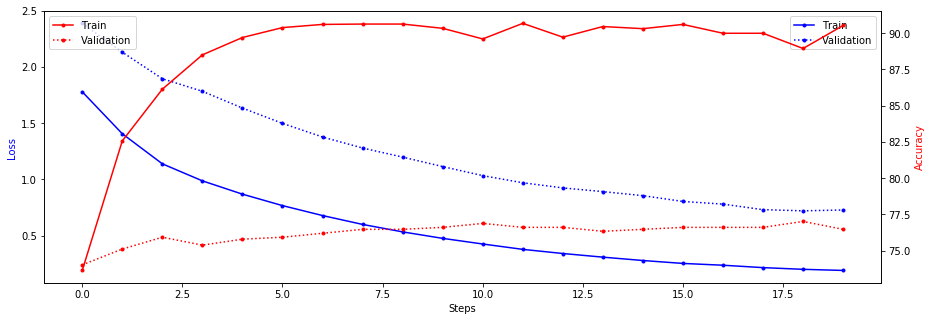

In [6]:
fig, ax1 = plt.subplots(figsize=(15, 5))
ax1.plot(loss_train, 'b.-')
ax1.set_ylabel('Loss', color='b')
ax1.plot(loss_val, 'b.:')
ax1.legend(['Train', 'Validation'])
ax2 = ax1.twinx()
ax2.plot(train_accs, 'r.-')
ax2.set_ylabel('Accuracy', color='r')
ax2.plot(val_accs, 'r.:')
ax2.legend(['Train', 'Validation'])
ax1.set_xlabel('Steps')
plt.show()

We can see that the accuracy on the validation set reaches a score of $77$% by the end of the 200 training epochs. 

Now we perform the prediction over the test set, and illustrate it as:
- Red: Vote yes;
- Blue: Vote no;
- White: Did not vote.

In [7]:
Pred_train = predict_labels(X_train)
Pred_test = predict_labels(X_test)

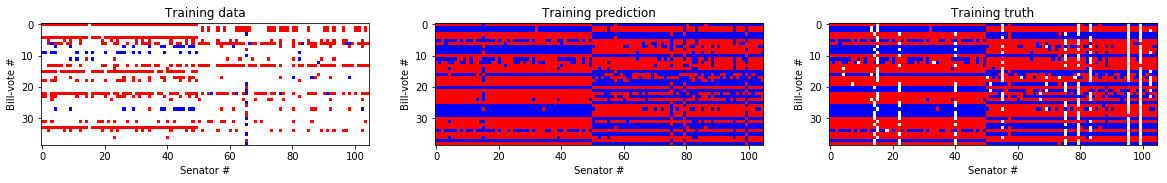

In [8]:
fig = plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training data')
plt.subplot(1,3,2)
plt.imshow(Pred_train, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training prediction')
plt.subplot(1,3,3)
plt.imshow(y_train, vmax = 1, vmin=-1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Training truth');

In [9]:
print('Accuracy train: {:.2f}%'.format(100*compute_set_accuracy(y_train, Pred_train)))

Accuracy train: 96.66%


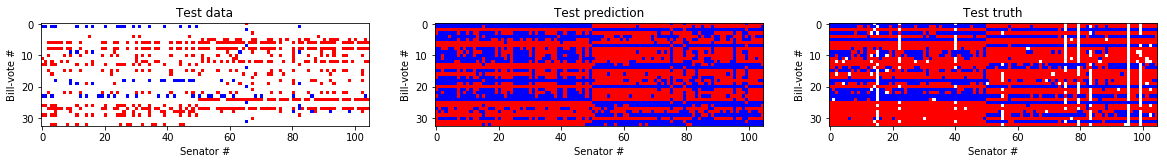

In [10]:
plt.figure(figsize=(20,10))
plt.subplot(1,3,1)
plt.imshow(X_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test data')
plt.subplot(1,3,2)
plt.imshow(Pred_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test prediction')
plt.subplot(1,3,3)
plt.imshow(y_test, vmax = 1, vmin= -1, cmap = mycmap)
plt.xlabel('Senator #')
plt.ylabel('Bill-vote #')
plt.title('Test truth');

In [11]:
print('Accuracy test: {:.2f} %'.format(100*compute_set_accuracy(y_test, Pred_test)))

Accuracy test: 82.46 %


To better visualize the regression results, the following example is presented in network layout form, where one cosponsorship profile is selected among the validation set to emphasize the result predicted by the CNN and the respective groundtruth.

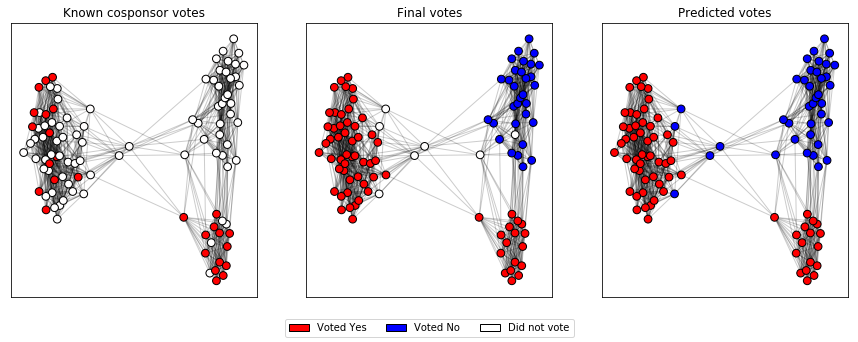

In [12]:
G = nx.from_numpy_matrix(A.todense())
coords = nx.spring_layout(G)

Pred_val = predict_labels(X_val)
plot_predictions(X_val[2], y_val[2], Pred_val[2], G, coords)
# plt.savefig('figs/net_cnn.pdf', bbox_inches = 'tight')

Note that the CNN is quite successfull in identifying the final vote pattern using as input the initial cosponsorship profile and the graph structure, resulting in an accuracy of 100% (since we do not consider absences in the prediction evaluation).

## 3 Analysis of all congresses

Next we extend the analysis to all US congresses, from Senate 105 to 115, where the same procedure detailed applied is for each of those Senates. The only exception is Senate 106, whose data provided by the ProPublica Congress API was inconsistent and faulty. 

In [13]:
Acc_tr = []
Acc_te = []
Err_tr = []
Err_te = []

for congress_nb in range(105, 116):
    if congress_nb != 106:
        X_train, X_val, X_test, y_train, y_val, y_test = get_train_test(senate_id = congress_nb, shuffle = True)
        A = compute_adjacency(y_train)
        L = compute_laplacian_list(A)
        params = set_params_cnn(X_train, params)
        loss_train, loss_val, train_accs, val_accs, model = run_CNN(L, params, X_train, y_train, X_val, y_val)
        Pred_train = predict_labels(X_train)
        Pred_test = predict_labels(X_test)

        err_tr, acc_tr = compute_prediction_err_acc(y_train, Pred_train)
        err_te, acc_te = compute_prediction_err_acc(y_test, Pred_test)

        Err_tr.append(err_tr)
        Err_te.append(err_te)
        Acc_tr.append(acc_tr)
        Acc_te.append(acc_te)
    

NN architecture
  input: M_0 = 100
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 100 * 32 / 1 = 3200
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 100 * 64 / 1 = 6400
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 100
    weights: M_2 * M_3 = 6400 * 100 = 640000
    biases: M_3 = 100
NN architecture
  input: M_0 = 101
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 101 * 32 / 1 = 3232
    weights: F_0 * F_1 * K_1 = 1 * 32 * 4 = 128
    biases: F_1 = 32
  layer 2: cgconv2
    representation: M_1 * F_2 / p_2 = 101 * 64 / 1 = 6464
    weights: F_1 * F_2 * K_2 = 32 * 64 * 4 = 8192
    biases: F_2 = 64
  layer 3: logits
    representation: M_3 = 101
    weights: M_2 * M_3 = 6464 * 101 = 652864
    biases: M_3 = 101
NN architecture
  input: M_0 = 100
  layer 1: cgconv1
    representation: M_0 * F_1 / p_1 = 100 * 32 / 1 = 3200


In [14]:
# Build dataframe with error and accuracy statistics for train and test sets.
c=0
df=pd.DataFrame()
for i in range(105, 116):
    if i != 106:
        df = df.append(pd.DataFrame(data=[Err_tr[c], Acc_tr[c], Err_te[c], Acc_te[c], [i for j in range(len(Err_tr[c]))]]).transpose())
        c+=1
df.columns = ['Err_tr', 'Acc_tr', 'Err_te', 'Acc_te', 'Congress']

Next we show the distribution of error and accuracy for the test set for each Senate. 

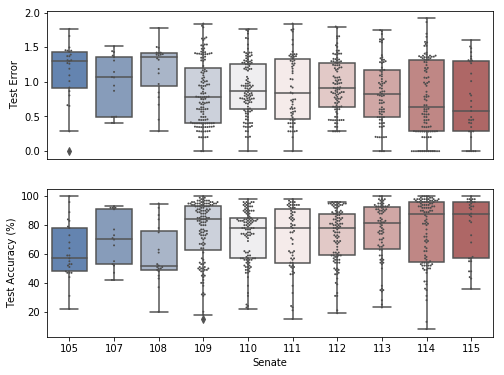

In [15]:
fig, ax= plt.subplots(2,1, figsize=(8,6))
sns.set(style="whitegrid")
sns.boxplot(x='Congress',y='Err_te', data=df, palette="vlag", ax=ax[0])
sns.swarmplot(x='Congress',y='Err_te', data=df, size=2, color=".3", ax=ax[0])
sns.boxplot(x='Congress',y='Acc_te', data=df, palette="vlag", ax=ax[1])
sns.swarmplot(x='Congress',y='Acc_te', data=df, size=2, color=".3", ax=ax[1])
ax[0].set_ylabel('Test Error')
ax[1].set_ylabel('Test Accuracy (%)')
ax[0].set_xticks([])
ax[0].set_xlabel('')

plt.xlabel('Senate')
plt.xticks(np.arange(10),[i for i in range(105,116) if i !=106]);
plt.savefig('figs/test_err_cnn.pdf')

We can see from the image above that for later Senates, the prediction accuracy tends to increase. This can be due to the fact that as the training data gets scarcer for the older Senates, the amount of information available may be insufficient to correctly train all parameters in the CNN. 

The mean training and test errors and accuracy scores, as well as their standard deviations, can be seen below:

In [16]:
df.groupby('Congress').mean()

,Err_tr,Acc_tr,Err_te,Acc_te
Congress,,,,
105.0,0.386327,88.137931,1.151240,61.560000
107.0,0.271573,93.950000,0.988657,69.250000
108.0,0.325602,88.875000,1.178439,59.200000
109.0,0.578014,84.717791,0.831039,75.923664
110.0,0.487341,83.920290,0.911905,72.053571
111.0,0.498713,83.974359,0.899211,71.000000
112.0,0.539656,83.816794,0.946748,72.400000
113.0,0.313680,90.906250,0.841079,75.512821
114.0,0.496464,84.232558,0.753823,76.500000


In [17]:
df.groupby('Congress').std()

,Err_tr,Acc_tr,Err_te,Acc_te
Congress,,,,
105.0,0.512123,16.715528,0.418507,19.564168
107.0,0.250460,3.817894,0.409836,19.014030
108.0,0.456948,12.546652,0.387927,19.845721
109.0,0.455819,16.612322,0.456652,21.106914
110.0,0.478867,17.847718,0.397389,18.778865
111.0,0.497312,18.258586,0.477156,22.230464
112.0,0.524954,19.095228,0.380953,18.812128
113.0,0.417772,12.065678,0.449047,20.268806
114.0,0.539125,19.274137,0.541947,22.719052
